<a href="https://colab.research.google.com/github/esihsi/colab-ML/blob/main/DDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [ ]:
class DDPMScheduler:
    """Beta schedule and diffusion utilities for DDPM"""

    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, schedule="cosine"):
        self.num_timesteps = num_timesteps
        if schedule == "linear":
            self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        elif schedule == "cosine":
            # Cosine schedule (Nichol & Dhariwal, 2021)
            # Better for image generation, prevents "static" artifacts
            steps = num_timesteps + 1
            x = torch.linspace(0, num_timesteps, steps)
            alphas_cumprod = torch.cos(((x / num_timesteps) + 0.008) / (1 + 0.008) * torch.pi * 0.5) ** 2
            alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
            betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
            self.betas = torch.clip(betas, 0.0001, 0.9999)

        # Calculate alphas
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)

        # Calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)

        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )

    def add_noise(self, x_0, t, noise=None):
        """Forward diffusion process: q(x_t | x_0)"""
        if noise is None:
            noise = torch.randn_like(x_0)

        # Reshape to allow broadcasting across feature dimensions
        # For 2D data (batch_size, 2) it becomes (batch_size, 1)
        # For image data (batch_size, 1, H, W) it becomes (batch_size, 1, 1, 1)
        reshape_dims = (x_0.shape[0],) + (1,) * (len(x_0.shape) - 1)

        sqrt_alpha_cumprod_t = self.sqrt_alphas_cumprod[t].view(reshape_dims)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(reshape_dims)

        # x_t = sqrt(alpha_cumprod_t) * x_0 + sqrt(1 - alpha_cumprod_t) * noise
        return sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise, noise

#==============================================================================
# PART 2: NEURAL NETWORK ARCHITECTURES
#==============================================================================

class SinusoidalPositionEmbeddings(nn.Module):
    """Sinusoidal time embeddings"""

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [ ]:
class SimpleMLP(nn.Module):
    """Simple MLP for 2D data denoising"""

    def __init__(self, input_dim=2, hidden_dim=128, time_dim=64):
        super().__init__()

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU()
        )

        self.network = nn.Sequential(
            nn.Linear(input_dim + time_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        x = torch.cat([x, t_emb], dim=-1)
        return self.network(x)


In [ ]:
class SimpleUNet(nn.Module):
    """Simple U-Net style network for MNIST"""

    def __init__(self, in_channels=1, time_dim=64):
        super().__init__()

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU()
        )

        # Downsampling
        self.conv1 = nn.Conv2d(in_channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # Time embedding projection
        self.time_proj = nn.Linear(time_dim, 128)

        # Upsampling
        self.conv4 = nn.ConvTranspose2d(128, 64, 3, padding=1)
        self.conv5 = nn.ConvTranspose2d(64, 32, 3, padding=1)
        self.conv6 = nn.ConvTranspose2d(32, in_channels, 3, padding=1)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_mlp(t)
        t_emb = self.time_proj(t_emb)

        # Encoder
        h1 = self.relu(self.conv1(x))
        h2 = self.relu(self.conv2(self.pool(h1)))
        h3 = self.relu(self.conv3(self.pool(h2)))

        # Add time embedding
        h3 = h3 + t_emb.view(-1, 128, 1, 1)

        # Decoder
        h4 = self.relu(self.conv4(self.upsample(h3)))
        h5 = self.relu(self.conv5(self.upsample(h4)))
        h6 = self.conv6(h5)

        return h6


In [ ]:
class Block(nn.Module):
    """Refined Block with Residual Connection"""
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)

        # Standard conv block
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

        # Transform (Up/Down sampling)
        if up:
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

    def forward(self, x, t):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))

        # Time Injection
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb

        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))

        # Apply Transform (Down/Up)
        return self.transform(h)

class BetterUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, time_dim=32):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU()
        )

        self.conv0 = nn.Conv2d(in_channels, 64, 3, padding=1)

        # Downsample
        self.down1 = Block(64, 128, time_dim)      # 28x28 -> 14x14
        self.down2 = Block(128, 256, time_dim)     # 14x14 -> 7x7

        # --- FIX: REMOVE EXTRA DOWNSAMPLING ---
        # Instead of squeezing to 1x1, we process at 7x7 using standard Convs
        self.bot1 = nn.Conv2d(256, 512, 3, padding=1)
        self.bot2 = nn.Conv2d(512, 512, 3, padding=1)
        self.bot3 = nn.Conv2d(512, 256, 3, padding=1)
        # ---------------------------------------

        # Upsample
        # up1 inputs: 256 (from bot3) + 256 (from down2 skip) = 512
        self.up1 = Block(512, 128, time_dim, up=True)

        # up2 inputs: 128 (from up1) + 128 (from down1 skip) = 256
        self.up2 = Block(256, 64, time_dim, up=True)

        self.out = nn.Conv2d(64, out_channels, 3, padding=1)

    def forward(self, x, t):
        t = self.time_mlp(t)
        x = self.conv0(x)

        d1 = self.down1(x, t)
        d2 = self.down2(d1, t)

        # Bottleneck (Now stays at 7x7)
        x = self.bot1(d2)
        x = F.relu(x)
        x = self.bot2(x)
        x = F.relu(x)
        x = self.bot3(x)
        x = F.relu(x)

        # Upsample (Concatenate Skip Connections)
        x = self.up1(torch.cat([x, d2], dim=1), t)
        x = self.up2(torch.cat([x, d1], dim=1), t)

        return self.out(x)

In [ ]:
import torch
import torch.nn as nn
import numpy as np

class DiTBlock(nn.Module):
    """
    A Transformer block with Adaptive Layer Norm (AdaLN).
    This is the core component of modern Diffusion Transformers (like Sora).
    """
    def __init__(self, hidden_size, num_heads, time_emb_dim, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.attn = nn.MultiheadAttention(hidden_size, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)

        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, mlp_hidden_dim),
            nn.GELU(),
            nn.Linear(mlp_hidden_dim, hidden_size),
        )

        # AdaLN: Regress shift (gamma) and scale (beta) from the time embedding
        # We output 6 parameters: shift/scale/gate for Attention, shift/scale/gate for MLP
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, 6 * hidden_size, bias=True)
        )

    def forward(self, x, t):
        # 1. Calculate modulation parameters from time t
        # chunk(6) splits the output into 6 parts
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = \
            self.adaLN_modulation(t).chunk(6, dim=1)

        # 2. Attention Block with Modulation
        # x_mod = norm(x) * (1 + scale) + shift
        x_mod = self.norm1(x) * (1 + scale_msa.unsqueeze(1)) + shift_msa.unsqueeze(1)
        x_attn, _ = self.attn(x_mod, x_mod, x_mod)
        x = x + gate_msa.unsqueeze(1) * x_attn

        # 3. MLP Block with Modulation
        x_mod = self.norm2(x) * (1 + scale_mlp.unsqueeze(1)) + shift_mlp.unsqueeze(1)
        x_mlp = self.mlp(x_mod)
        x = x + gate_mlp.unsqueeze(1) * x_mlp

        return x

class MiniDiT(nn.Module):
    """
    Corrected MiniDiT with proper initialization and Positional Embeddings.
    """
    def __init__(self,
                 in_channels=1,
                 patch_size=4,
                 hidden_size=256,
                 depth=6,
                 num_heads=4,
                 time_emb_dim=64):
        super().__init__()
        self.patch_size = patch_size
        self.in_channels = in_channels

        # 1. Time Embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # 2. Patch Embedding
        self.patch_embed = nn.Conv2d(in_channels, hidden_size,
                                     kernel_size=patch_size, stride=patch_size)

        # 3. Positional Embedding (FIXED: Random Init, not Zeros)
        num_patches = (28 // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, hidden_size) * 0.02)

        # 4. Transformer Blocks
        self.blocks = nn.ModuleList([
            DiTBlock(hidden_size, num_heads, time_emb_dim) for _ in range(depth)
        ])

        # 5. Final Layer
        self.final_norm = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.final_adaLN = nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, 2 * hidden_size))
        self.final_linear = nn.Linear(hidden_size, patch_size * patch_size * in_channels)

        # 6. Apply Weight Initialization (CRITICAL FOR DiT)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

        # Zero-out the last layer of AdaLN modulation (DiT Trick)
        # This makes the block act as Identity at the start of training
        if isinstance(m, DiTBlock):
            # The adaLN_modulation last layer is the 2nd Linear layer in the Sequential
            nn.init.constant_(m.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(m.adaLN_modulation[-1].bias, 0)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)

        # Patchify
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)

        # Add Positional Embeddings
        x = x + self.pos_embed

        for block in self.blocks:
            x = block(x, t_emb)

        # Unpatchify
        shift, scale = self.final_adaLN(t_emb).chunk(2, dim=1)
        x = self.final_norm(x) * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)
        x = self.final_linear(x)

        # Reshape logic
        B, N, _ = x.shape
        grid = int(N**0.5)
        x = x.view(B, grid, grid, self.patch_size, self.patch_size, self.in_channels)
        x = x.permute(0, 5, 1, 3, 2, 4)
        x = x.reshape(B, self.in_channels, 28, 28)

        return x

In [ ]:
class ConvNextBlock(nn.Module):
    """
    A modern CNN block that mimics Transformer design.
    """
    def __init__(self, in_channels, out_channels, time_emb_dim, mult=2):
        super().__init__()
        self.mlp_layer = nn.Sequential(
            nn.GELU(),
            nn.Linear(time_emb_dim, in_channels)
        )

        self.ds_conv = nn.Conv2d(in_channels, in_channels, kernel_size=7, padding=3, groups=in_channels)
        self.net = nn.Sequential(
            nn.GroupNorm(1, in_channels),
            nn.Conv2d(in_channels, out_channels * mult, kernel_size=3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, out_channels * mult),
            nn.Conv2d(out_channels * mult, out_channels, kernel_size=3, padding=1),
        )

        # Residual connection handling
        self.res_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t):
        h = self.ds_conv(x)

        # Time injection (Shift and Scale is better, but adding is simpler)
        time_emb = self.mlp_layer(t)
        time_emb = time_emb[(..., ) + (None, ) * 2] # Resize to (B, C, 1, 1)
        h = h + time_emb

        h = self.net(h)
        return h + self.res_conv(x)

class ConvNextUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, time_dim=32):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU()
        )

        self.conv0 = nn.Conv2d(in_channels, 64, 3, padding=1)

        # Downsample
        self.down1 = ConvNextBlock(64, 128, time_dim)
        self.down2 = ConvNextBlock(128, 256, time_dim)

        # Bottleneck (ConvNeXt is powerful enough to handle 7x7 without attention)
        self.bot1 = ConvNextBlock(256, 512, time_dim)
        self.bot2 = ConvNextBlock(512, 512, time_dim)
        self.bot3 = ConvNextBlock(512, 256, time_dim)

        # Upsample
        self.up1 = ConvNextBlock(512, 128, time_dim) # 256 + 256
        self.up2 = ConvNextBlock(256, 64, time_dim)  # 128 + 128

        self.out = nn.Conv2d(64, out_channels, 3, padding=1)

        # Upsample/Downsample helpers
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, x, t):
        t = self.time_mlp(t)
        x = self.conv0(x)

        # Down
        d1 = self.down1(x, t)
        x = self.maxpool(d1)

        d2 = self.down2(x, t)
        x = self.maxpool(d2)

        # Bottleneck
        x = self.bot1(x, t)
        x = self.bot2(x, t)
        x = self.bot3(x, t)

        # Up
        x = self.upsample(x)
        x = torch.cat([x, d2], dim=1)
        x = self.up1(x, t)

        x = self.upsample(x)
        x = torch.cat([x, d1], dim=1)
        x = self.up2(x, t)

        return self.out(x)

In [ ]:
#==============================================================================
# PART 3: DATASET GENERATORS
#==============================================================================

class Synthetic2DDataset(Dataset):
    """2D Synthetic dataset: y = x/||x|| where x ~ N(0, I)"""

    def __init__(self, num_samples=10000):
        # Sample from N(0, I)
        x = np.random.randn(num_samples, 2)

        # Normalize to unit circle: y = x / ||x||
        norms = np.linalg.norm(x, axis=1, keepdims=True)
        y = x / norms

        self.data = torch.FloatTensor(y)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def get_mnist_dataloader(batch_size=64, train=True):
    """Load MNIST dataset"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])

    dataset = datasets.MNIST(
        root='./data',
        train=train,
        download=True,
        transform=transform
    )

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=train,
        num_workers=2
    )

    return dataloader


In [ ]:
class EMA:
    """
    Exponential Moving Average for model parameters.
    References: https://github.com/lucidrains/ema-pytorch
    """
    def __init__(self, beta=0.995):
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

In [ ]:
#==============================================================================
# PART 4: TRAINING FUNCTIONS
#==============================================================================

import copy

def train_ddpm(model, dataloader, scheduler, num_epochs, lr):
    """Train DDPM model with EMA"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    # --- EMA SETUP ---
    # Create a copy of the model for EMA
    ema = EMA(beta=0.995)
    ema_model = copy.deepcopy(model).eval().requires_grad_(False)
    # -----------------

    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in pbar:
            if isinstance(batch, list):
                x_0 = batch[0].to(device)
            else:
                x_0 = batch.to(device)

            t = torch.randint(0, scheduler.num_timesteps, (x_0.shape[0],), device=device)
            noise = torch.randn_like(x_0)
            x_t, _ = scheduler.add_noise(x_0, t, noise)

            # Predict noise
            predicted_noise = model(x_t, t)
            loss = F.mse_loss(predicted_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # --- UPDATE EMA ---
            ema.step_ema(ema_model, model)
            # ------------------

            epoch_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}: Average Loss = {avg_loss:.6f}")

    # Return the EMA model instead of the raw model
    return losses, ema_model

In [ ]:
#==============================================================================
# PART 5: SAMPLING FUNCTIONS
#==============================================================================

@torch.no_grad()
def sample_ddpm(model, scheduler, shape, num_samples=1, save_trajectory=False):
    """
    Corrected Reverse diffusion sampling (Algorithm 2 from Ho et al. 2020)
    """
    model.eval()

    # 1. Start from pure noise x_T
    x = torch.randn(num_samples, *shape).to(device)

    trajectory = [x.cpu().numpy()] if save_trajectory else []

    # 2. Reverse process: x_T -> x_{T-1} -> ... -> x_0
    for t in reversed(range(scheduler.num_timesteps)):
        t_batch = torch.full((num_samples,), t, device=device, dtype=torch.long)

        # Predict noise noise_theta
        predicted_noise = model(x, t_batch)

        # Get diffusion parameters for this step
        beta_t = scheduler.betas[t]
        alpha_t = scheduler.alphas[t]
        alpha_bar_t = scheduler.alphas_cumprod[t]

        # 3. Calculate the Mean (mu_theta)
        # Formula: 1/sqrt(alpha_t) * (x_t - (beta_t / sqrt(1 - alpha_bar_t)) * predicted_noise)

        # We need 1 / sqrt(alpha_t)
        coeff1 = 1 / torch.sqrt(alpha_t)

        # We need beta_t / sqrt(1 - alpha_bar_t)
        coeff2 = beta_t / torch.sqrt(1 - alpha_bar_t)

        # Combine to get the mean
        mu_theta = coeff1 * (x - coeff2 * predicted_noise)

        # 4. Add Noise (sigma_t * z)
        # Use beta_t as the variance (Option 1 in the paper)
        if t > 0:
            noise = torch.randn_like(x)
            #sigma_t = torch.sqrt(beta_t)
            posterior_variance_t = scheduler.posterior_variance[t]
            sigma_t = torch.sqrt(posterior_variance_t)
            x = mu_theta + sigma_t * noise
        else:
            x = mu_theta # No noise at the final step

        if save_trajectory and t % 100 == 0:
            trajectory.append(x.cpu().numpy())

    if save_trajectory:
        return x.cpu().numpy(), trajectory
    return x.cpu().numpy()

In [ ]:
#==============================================================================
# PART 6: VISUALIZATION FUNCTIONS
#==============================================================================

def visualize_2d_results(model, scheduler, dataset, num_samples=1000):
    """Visualize 2D synthetic data results"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: Original data distribution
    original_data = dataset.data.numpy()
    axes[0].scatter(original_data[:, 0], original_data[:, 1],
                   alpha=0.5, s=10, c='blue', label='Original Data')
    axes[0].set_title('Original Data Distribution (Unit Circle)', fontsize=14)
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].axis('equal')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # Plot 2: Generated samples
    generated_samples = sample_ddpm(model, scheduler, shape=(2,), num_samples=num_samples)
    axes[1].scatter(generated_samples[:, 0], generated_samples[:, 1],
                   alpha=0.5, s=10, c='red', label='Generated Samples')
    axes[1].set_title('Generated Samples', fontsize=14)
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    axes[1].axis('equal')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    # Plot 3: Overlay
    axes[2].scatter(original_data[:500, 0], original_data[:500, 1],
                   alpha=0.3, s=10, c='blue', label='Original')
    axes[2].scatter(generated_samples[:500, 0], generated_samples[:500, 1],
                   alpha=0.3, s=10, c='red', label='Generated')
    axes[2].set_title('Overlay Comparison', fontsize=14)
    axes[2].set_xlabel('x')
    axes[2].set_ylabel('y')
    axes[2].axis('equal')
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()

    plt.tight_layout()
    plt.show()


def visualize_denoising_trajectory(model, scheduler, num_trajectories=5):
    """Visualize denoising trajectories for 2D data"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    colors = plt.cm.viridis(np.linspace(0, 1, num_trajectories))

    for i in range(num_trajectories):
        _, trajectory = sample_ddpm(model, scheduler, shape=(2,),
                                   num_samples=1, save_trajectory=True)
        trajectory = np.array(trajectory).squeeze()

        # Plot trajectory
        axes[0].plot(trajectory[:, 0], trajectory[:, 1],
                    alpha=0.7, linewidth=2, color=colors[i])
        axes[0].scatter(trajectory[0, 0], trajectory[0, 1],
                       s=100, c=[colors[i]], marker='o', edgecolors='black',
                       linewidths=2, label=f'Start {i+1}')
        axes[0].scatter(trajectory[-1, 0], trajectory[-1, 1],
                       s=100, c=[colors[i]], marker='*', edgecolors='black',
                       linewidths=2)

    axes[0].set_title('Denoising Trajectories (Noise → Data)', fontsize=14)
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].axis('equal')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    # Plot distance to origin over time
    for i in range(num_trajectories):
        _, trajectory = sample_ddpm(model, scheduler, shape=(2,),
                                   num_samples=1, save_trajectory=True)
        trajectory = np.array(trajectory).squeeze()
        distances = np.linalg.norm(trajectory, axis=1)
        axes[1].plot(distances, alpha=0.7, linewidth=2, color=colors[i])

    axes[1].set_title('Distance to Origin Over Denoising Steps', fontsize=14)
    axes[1].set_xlabel('Denoising Step')
    axes[1].set_ylabel('Distance to Origin')
    axes[1].axhline(y=1, color='red', linestyle='--', label='Target (Unit Circle)')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    plt.tight_layout()
    plt.show()


def visualize_mnist_results(model, scheduler, num_samples=16):
    """Visualize MNIST generation results"""
    samples = sample_ddpm(model, scheduler, shape=(1, 28, 28), num_samples=num_samples)

    # Denormalize from [-1, 1] to [0, 1]
    samples = (samples + 1) / 2
    samples = np.clip(samples, 0, 1)

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(num_samples):
        axes[i].imshow(samples[i, 0], cmap='gray')
        axes[i].axis('off')

    plt.suptitle('Generated MNIST Digits', fontsize=16)
    plt.tight_layout()
    plt.show()


def visualize_mnist_denoising_process(model, scheduler):
    """Visualize the denoising process for a single MNIST sample"""
    _, trajectory = sample_ddpm(model, scheduler, shape=(1, 28, 28),
                               num_samples=1, save_trajectory=True)

    # Select evenly spaced frames
    num_frames = min(10, len(trajectory))
    indices = np.linspace(0, len(trajectory)-1, num_frames, dtype=int)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        img = trajectory[idx][0, 0]
        img = (img + 1) / 2  # Denormalize
        img = np.clip(img, 0, 1)

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Step {idx}')
        axes[i].axis('off')

    plt.suptitle('MNIST Denoising Process (Noise → Digit)', fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_training_losses(losses):
    """Plot training losses"""
    plt.figure(figsize=(10, 5))
    plt.plot(losses, linewidth=2)
    plt.title('Training Loss Over Epochs', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


DENOISING DIFFUSION PROBABILISTIC MODEL (DDPM)
Implementation for 2D Synthetic Data and MNIST



EXPERIMENT 2: MNIST DIGIT GENERATION

1. Loading MNIST dataset...
2. Initializing model and scheduler...
3. Training model...


Epoch 1/100: 100%|██████████| 938/938 [00:59<00:00, 15.75it/s, loss=0.0584]


Epoch 1: Average Loss = 0.103321


Epoch 2/100: 100%|██████████| 938/938 [00:59<00:00, 15.77it/s, loss=0.0763]


Epoch 2: Average Loss = 0.054371


Epoch 3/100: 100%|██████████| 938/938 [00:59<00:00, 15.72it/s, loss=0.0677]


Epoch 3: Average Loss = 0.051583


Epoch 4/100: 100%|██████████| 938/938 [00:59<00:00, 15.71it/s, loss=0.0442]


Epoch 4: Average Loss = 0.050142


Epoch 5/100: 100%|██████████| 938/938 [00:59<00:00, 15.66it/s, loss=0.0444]


Epoch 5: Average Loss = 0.049465


Epoch 6/100: 100%|██████████| 938/938 [00:59<00:00, 15.68it/s, loss=0.0548]


Epoch 6: Average Loss = 0.048568


Epoch 7/100: 100%|██████████| 938/938 [00:59<00:00, 15.66it/s, loss=0.039]


Epoch 7: Average Loss = 0.048193


Epoch 8/100: 100%|██████████| 938/938 [00:59<00:00, 15.71it/s, loss=0.0492]


Epoch 8: Average Loss = 0.047089


Epoch 9/100: 100%|██████████| 938/938 [00:59<00:00, 15.67it/s, loss=0.0414]


Epoch 9: Average Loss = 0.045601


Epoch 10/100: 100%|██████████| 938/938 [00:59<00:00, 15.68it/s, loss=0.0371]


Epoch 10: Average Loss = 0.039273


Epoch 11/100: 100%|██████████| 938/938 [00:59<00:00, 15.69it/s, loss=0.0371]


Epoch 11: Average Loss = 0.033267


Epoch 12/100: 100%|██████████| 938/938 [00:59<00:00, 15.70it/s, loss=0.0279]


Epoch 12: Average Loss = 0.030664


Epoch 13/100: 100%|██████████| 938/938 [00:59<00:00, 15.66it/s, loss=0.0411]


Epoch 13: Average Loss = 0.029054


Epoch 14/100: 100%|██████████| 938/938 [00:59<00:00, 15.69it/s, loss=0.0337]


Epoch 14: Average Loss = 0.027686


Epoch 15/100: 100%|██████████| 938/938 [00:59<00:00, 15.69it/s, loss=0.0336]


Epoch 15: Average Loss = 0.027071


Epoch 16/100: 100%|██████████| 938/938 [00:59<00:00, 15.68it/s, loss=0.0291]


Epoch 16: Average Loss = 0.026476


Epoch 17/100: 100%|██████████| 938/938 [00:59<00:00, 15.66it/s, loss=0.0261]


Epoch 17: Average Loss = 0.025681


Epoch 18/100: 100%|██████████| 938/938 [00:59<00:00, 15.68it/s, loss=0.0224]


Epoch 18: Average Loss = 0.025994


Epoch 19/100: 100%|██████████| 938/938 [00:59<00:00, 15.65it/s, loss=0.0313]


Epoch 19: Average Loss = 0.025476


Epoch 20/100: 100%|██████████| 938/938 [00:59<00:00, 15.66it/s, loss=0.0335]


Epoch 20: Average Loss = 0.025434


Epoch 21/100: 100%|██████████| 938/938 [00:59<00:00, 15.72it/s, loss=0.019]


Epoch 21: Average Loss = 0.024915


Epoch 22/100: 100%|██████████| 938/938 [00:59<00:00, 15.70it/s, loss=0.0263]


Epoch 22: Average Loss = 0.024530


Epoch 23/100: 100%|██████████| 938/938 [00:59<00:00, 15.65it/s, loss=0.0273]


Epoch 23: Average Loss = 0.024638


Epoch 24/100: 100%|██████████| 938/938 [00:59<00:00, 15.64it/s, loss=0.0305]


Epoch 24: Average Loss = 0.024205


Epoch 25/100: 100%|██████████| 938/938 [00:59<00:00, 15.65it/s, loss=0.0198]


Epoch 25: Average Loss = 0.024233


Epoch 26/100: 100%|██████████| 938/938 [00:59<00:00, 15.68it/s, loss=0.0219]


Epoch 26: Average Loss = 0.024180


Epoch 27/100: 100%|██████████| 938/938 [01:00<00:00, 15.63it/s, loss=0.0188]


Epoch 27: Average Loss = 0.023852


Epoch 28/100: 100%|██████████| 938/938 [00:59<00:00, 15.65it/s, loss=0.0223]


Epoch 28: Average Loss = 0.023717


Epoch 29/100: 100%|██████████| 938/938 [00:59<00:00, 15.68it/s, loss=0.022]


Epoch 29: Average Loss = 0.023827


Epoch 30/100: 100%|██████████| 938/938 [00:59<00:00, 15.66it/s, loss=0.0239]


Epoch 30: Average Loss = 0.023598


Epoch 31/100: 100%|██████████| 938/938 [00:59<00:00, 15.65it/s, loss=0.0345]


Epoch 31: Average Loss = 0.023460


Epoch 32/100: 100%|██████████| 938/938 [00:59<00:00, 15.67it/s, loss=0.0238]


Epoch 32: Average Loss = 0.023462


Epoch 33/100: 100%|██████████| 938/938 [00:59<00:00, 15.64it/s, loss=0.0318]


Epoch 33: Average Loss = 0.023577


Epoch 34/100: 100%|██████████| 938/938 [00:59<00:00, 15.68it/s, loss=0.0356]


Epoch 34: Average Loss = 0.023420


Epoch 35/100: 100%|██████████| 938/938 [00:59<00:00, 15.68it/s, loss=0.0214]


Epoch 35: Average Loss = 0.023267


Epoch 36/100: 100%|██████████| 938/938 [00:59<00:00, 15.64it/s, loss=0.0214]


Epoch 36: Average Loss = 0.023257


Epoch 37/100: 100%|██████████| 938/938 [00:59<00:00, 15.66it/s, loss=0.0169]


Epoch 37: Average Loss = 0.023049


Epoch 38/100: 100%|██████████| 938/938 [00:59<00:00, 15.67it/s, loss=0.013]


Epoch 38: Average Loss = 0.023043


Epoch 39/100: 100%|██████████| 938/938 [00:59<00:00, 15.67it/s, loss=0.0277]


Epoch 39: Average Loss = 0.023225


Epoch 40/100: 100%|██████████| 938/938 [00:59<00:00, 15.65it/s, loss=0.0229]


Epoch 40: Average Loss = 0.022851


Epoch 41/100: 100%|██████████| 938/938 [00:59<00:00, 15.67it/s, loss=0.0223]


Epoch 41: Average Loss = 0.023148


Epoch 42/100: 100%|██████████| 938/938 [00:59<00:00, 15.67it/s, loss=0.0298]


Epoch 42: Average Loss = 0.023007


Epoch 43/100: 100%|██████████| 938/938 [00:59<00:00, 15.69it/s, loss=0.0204]


Epoch 43: Average Loss = 0.022729


Epoch 44/100: 100%|██████████| 938/938 [00:59<00:00, 15.69it/s, loss=0.0221]


Epoch 44: Average Loss = 0.022724


Epoch 45/100: 100%|██████████| 938/938 [00:59<00:00, 15.68it/s, loss=0.0271]


Epoch 45: Average Loss = 0.022445


Epoch 46/100: 100%|██████████| 938/938 [00:59<00:00, 15.70it/s, loss=0.0311]


Epoch 46: Average Loss = 0.022717


Epoch 47/100: 100%|██████████| 938/938 [00:59<00:00, 15.71it/s, loss=0.0167]


Epoch 47: Average Loss = 0.022588


Epoch 48/100: 100%|██████████| 938/938 [00:59<00:00, 15.69it/s, loss=0.0182]


Epoch 48: Average Loss = 0.022387


Epoch 49/100: 100%|██████████| 938/938 [00:59<00:00, 15.72it/s, loss=0.0271]


Epoch 49: Average Loss = 0.022362


Epoch 50/100: 100%|██████████| 938/938 [00:59<00:00, 15.71it/s, loss=0.0268]


Epoch 50: Average Loss = 0.022523


Epoch 51/100: 100%|██████████| 938/938 [00:59<00:00, 15.72it/s, loss=0.0164]


Epoch 51: Average Loss = 0.022206


Epoch 52/100: 100%|██████████| 938/938 [00:59<00:00, 15.72it/s, loss=0.0244]


Epoch 52: Average Loss = 0.022177


Epoch 53/100: 100%|██████████| 938/938 [00:59<00:00, 15.69it/s, loss=0.0177]


Epoch 53: Average Loss = 0.022571


Epoch 54/100: 100%|██████████| 938/938 [00:59<00:00, 15.69it/s, loss=0.0177]


Epoch 54: Average Loss = 0.022736


Epoch 55/100: 100%|██████████| 938/938 [00:59<00:00, 15.67it/s, loss=0.0244]


Epoch 55: Average Loss = 0.022197


Epoch 56/100: 100%|██████████| 938/938 [00:59<00:00, 15.71it/s, loss=0.0192]


Epoch 56: Average Loss = 0.022345


Epoch 57/100: 100%|██████████| 938/938 [00:59<00:00, 15.71it/s, loss=0.0138]


Epoch 57: Average Loss = 0.022312


Epoch 58/100: 100%|██████████| 938/938 [00:59<00:00, 15.75it/s, loss=0.0222]


Epoch 58: Average Loss = 0.022169


Epoch 59/100: 100%|██████████| 938/938 [00:59<00:00, 15.78it/s, loss=0.0231]


Epoch 59: Average Loss = 0.022233


Epoch 60/100: 100%|██████████| 938/938 [00:59<00:00, 15.75it/s, loss=0.0245]


Epoch 60: Average Loss = 0.022189


Epoch 61/100: 100%|██████████| 938/938 [00:59<00:00, 15.74it/s, loss=0.0219]


Epoch 61: Average Loss = 0.022155


Epoch 62/100: 100%|██████████| 938/938 [00:59<00:00, 15.73it/s, loss=0.0201]


Epoch 62: Average Loss = 0.022074


Epoch 63/100: 100%|██████████| 938/938 [00:59<00:00, 15.74it/s, loss=0.0192]


Epoch 63: Average Loss = 0.022041


Epoch 64/100: 100%|██████████| 938/938 [00:59<00:00, 15.76it/s, loss=0.0208]


Epoch 64: Average Loss = 0.021886


Epoch 65/100: 100%|██████████| 938/938 [00:59<00:00, 15.74it/s, loss=0.0129]


Epoch 65: Average Loss = 0.021833


Epoch 66/100: 100%|██████████| 938/938 [00:59<00:00, 15.76it/s, loss=0.0211]


Epoch 66: Average Loss = 0.021929


Epoch 67/100: 100%|██████████| 938/938 [00:59<00:00, 15.79it/s, loss=0.0208]


Epoch 67: Average Loss = 0.022098


Epoch 68/100: 100%|██████████| 938/938 [00:59<00:00, 15.77it/s, loss=0.0183]


Epoch 68: Average Loss = 0.022236


Epoch 69/100: 100%|██████████| 938/938 [00:59<00:00, 15.79it/s, loss=0.0201]


Epoch 69: Average Loss = 0.021875


Epoch 70/100: 100%|██████████| 938/938 [00:59<00:00, 15.85it/s, loss=0.0186]


Epoch 70: Average Loss = 0.021895


Epoch 71/100: 100%|██████████| 938/938 [00:59<00:00, 15.73it/s, loss=0.0236]


Epoch 71: Average Loss = 0.021731


Epoch 72/100: 100%|██████████| 938/938 [00:59<00:00, 15.75it/s, loss=0.0201]


Epoch 72: Average Loss = 0.021835


Epoch 73/100: 100%|██████████| 938/938 [00:59<00:00, 15.72it/s, loss=0.0275]


Epoch 73: Average Loss = 0.021765


Epoch 74/100: 100%|██████████| 938/938 [00:59<00:00, 15.74it/s, loss=0.0232]


Epoch 74: Average Loss = 0.021767


Epoch 75/100: 100%|██████████| 938/938 [00:59<00:00, 15.71it/s, loss=0.0193]


Epoch 75: Average Loss = 0.021923


Epoch 76/100: 100%|██████████| 938/938 [00:59<00:00, 15.75it/s, loss=0.0254]


Epoch 76: Average Loss = 0.021688


Epoch 77/100: 100%|██████████| 938/938 [00:59<00:00, 15.73it/s, loss=0.0154]


Epoch 77: Average Loss = 0.021772


Epoch 78/100: 100%|██████████| 938/938 [00:59<00:00, 15.75it/s, loss=0.023]


Epoch 78: Average Loss = 0.021989


Epoch 79/100: 100%|██████████| 938/938 [00:59<00:00, 15.70it/s, loss=0.0153]


Epoch 79: Average Loss = 0.021989


Epoch 80/100: 100%|██████████| 938/938 [01:00<00:00, 15.62it/s, loss=0.0256]


Epoch 80: Average Loss = 0.021591


Epoch 81/100: 100%|██████████| 938/938 [00:59<00:00, 15.66it/s, loss=0.0246]


Epoch 81: Average Loss = 0.022019


Epoch 82/100: 100%|██████████| 938/938 [00:59<00:00, 15.64it/s, loss=0.0258]


Epoch 82: Average Loss = 0.021778


Epoch 83/100: 100%|██████████| 938/938 [01:00<00:00, 15.60it/s, loss=0.0151]


Epoch 83: Average Loss = 0.021688


Epoch 84/100: 100%|██████████| 938/938 [00:59<00:00, 15.65it/s, loss=0.0338]


Epoch 84: Average Loss = 0.021425


Epoch 85/100: 100%|██████████| 938/938 [00:59<00:00, 15.65it/s, loss=0.0219]


Epoch 85: Average Loss = 0.021527


Epoch 86/100: 100%|██████████| 938/938 [01:00<00:00, 15.61it/s, loss=0.018]


Epoch 86: Average Loss = 0.021404


Epoch 87/100: 100%|██████████| 938/938 [01:00<00:00, 15.58it/s, loss=0.0288]


Epoch 87: Average Loss = 0.021443


Epoch 88/100: 100%|██████████| 938/938 [01:00<00:00, 15.59it/s, loss=0.0172]


Epoch 88: Average Loss = 0.021664


Epoch 89/100: 100%|██████████| 938/938 [01:00<00:00, 15.61it/s, loss=0.0217]


Epoch 89: Average Loss = 0.021656


Epoch 90/100: 100%|██████████| 938/938 [01:00<00:00, 15.61it/s, loss=0.0244]


Epoch 90: Average Loss = 0.021479


Epoch 91/100: 100%|██████████| 938/938 [00:59<00:00, 15.64it/s, loss=0.0193]


Epoch 91: Average Loss = 0.021469


Epoch 92/100: 100%|██████████| 938/938 [01:00<00:00, 15.63it/s, loss=0.0264]


Epoch 92: Average Loss = 0.021451


Epoch 93/100: 100%|██████████| 938/938 [00:59<00:00, 15.64it/s, loss=0.0168]


Epoch 93: Average Loss = 0.021421


Epoch 94/100: 100%|██████████| 938/938 [00:59<00:00, 15.65it/s, loss=0.0189]


Epoch 94: Average Loss = 0.021546


Epoch 95/100: 100%|██████████| 938/938 [01:00<00:00, 15.61it/s, loss=0.0208]


Epoch 95: Average Loss = 0.021363


Epoch 96/100: 100%|██████████| 938/938 [00:59<00:00, 15.63it/s, loss=0.0361]


Epoch 96: Average Loss = 0.021298


Epoch 97/100: 100%|██████████| 938/938 [01:00<00:00, 15.61it/s, loss=0.0232]


Epoch 97: Average Loss = 0.021251


Epoch 98/100: 100%|██████████| 938/938 [01:00<00:00, 15.61it/s, loss=0.0187]


Epoch 98: Average Loss = 0.021488


Epoch 99/100: 100%|██████████| 938/938 [01:00<00:00, 15.63it/s, loss=0.0266]


Epoch 99: Average Loss = 0.021484


Epoch 100/100: 100%|██████████| 938/938 [01:00<00:00, 15.62it/s, loss=0.0203]


Epoch 100: Average Loss = 0.021271

4. Plotting training losses...


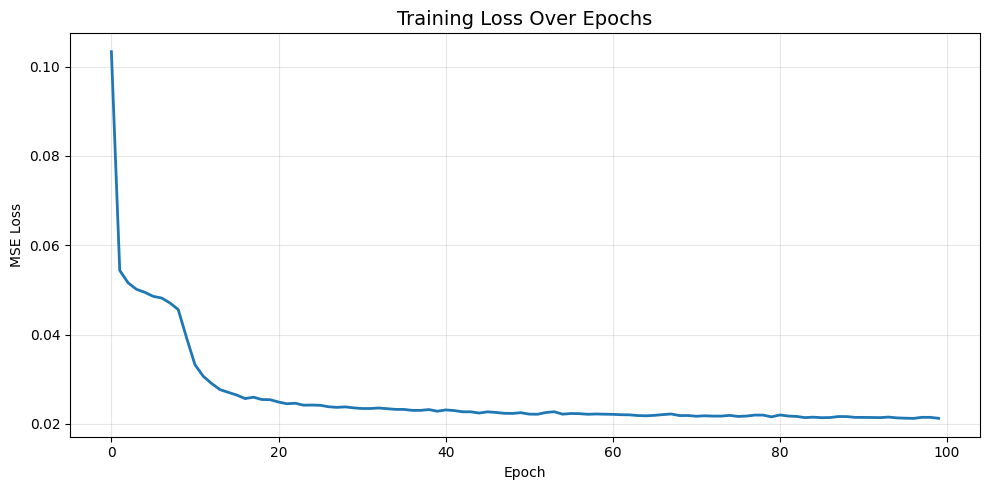

5. Visualizing generated digits...


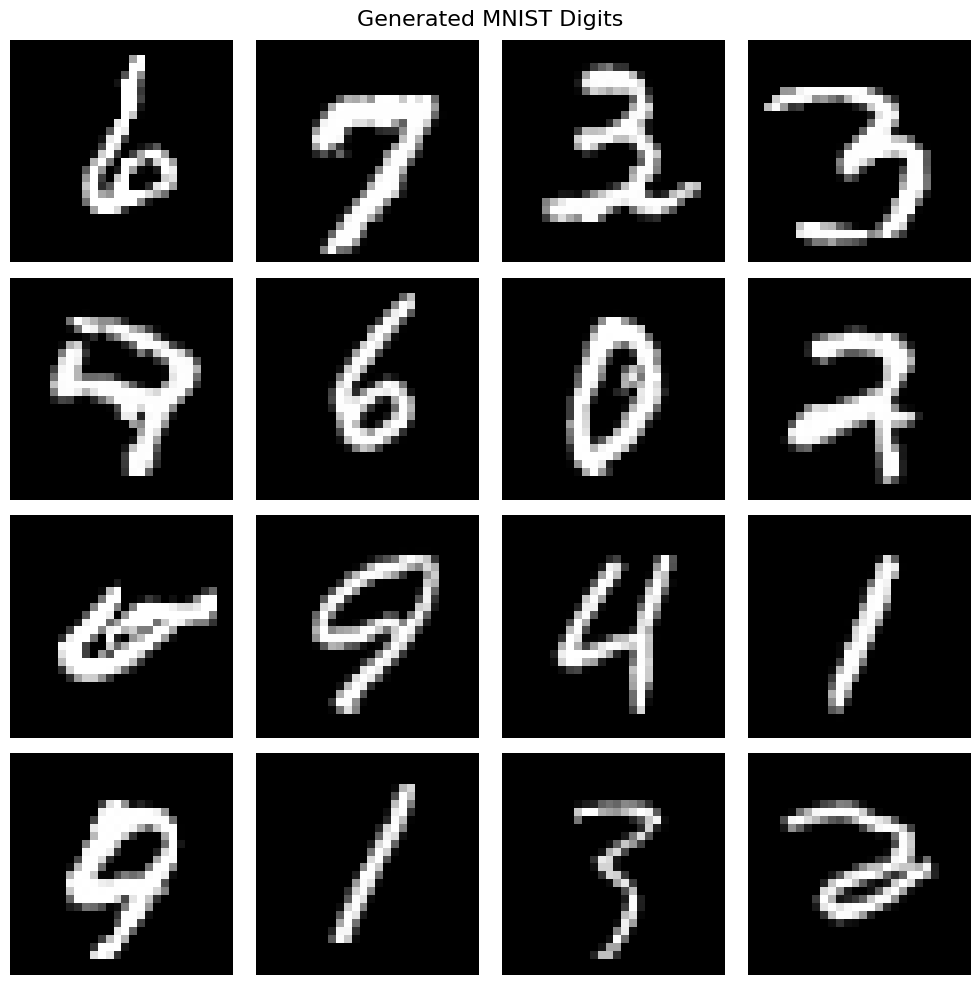

6. Visualizing denoising process...


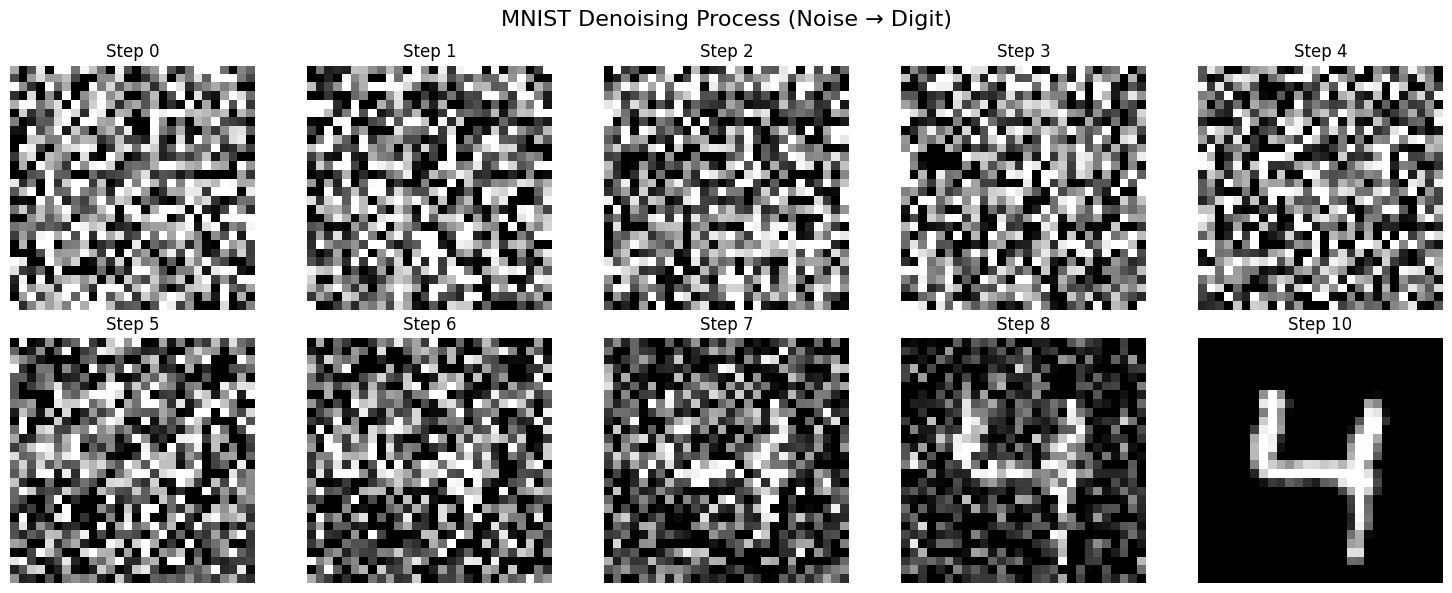


✓ MNIST Experiment Complete!

ALL EXPERIMENTS COMPLETE!


In [ ]:
#!pip install --upgrade pip
#!pip install --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

#==============================================================================
# PART 3: DATASET GENERATORS
#==============================================================================

class Synthetic2DDataset(Dataset):
    """2D Synthetic dataset: y = x/||x|| where x ~ N(0, I)"""

    def __init__(self, num_samples=10000):
        # Sample from N(0, I)
        x = np.random.randn(num_samples, 2)

        # Normalize to unit circle: y = x / ||x||
        norms = np.linalg.norm(x, axis=1, keepdims=True)
        y = x / norms

        self.data = torch.FloatTensor(y)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def get_mnist_dataloader(batch_size=64, train=True):
    """Load MNIST dataset"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])

    dataset = datasets.MNIST(
        root='./data',
        train=train,
        download=True,
        transform=transform
    )

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=train,
        num_workers=2
    )

    return dataloader

#==============================================================================
# PART 7: MAIN EXECUTION
#==============================================================================

def main_2d_experiment():
    """Main function for 2D synthetic data experiment"""
    print("="*80)
    print("EXPERIMENT 1: 2D SYNTHETIC DATA (Unit Circle)")
    print("="*80)

    # Create dataset
    print("\n1. Creating 2D synthetic dataset...")
    dataset = Synthetic2DDataset(num_samples=100000)
    dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

    # Create model and scheduler
    print("2. Initializing model and scheduler...")
    model = SimpleMLP(input_dim=2, hidden_dim=128)
    scheduler = DDPMScheduler(num_timesteps=1000, schedule="cosine")
    # Move scheduler's internal tensors to the correct device
    scheduler.betas = scheduler.betas.to(device)
    scheduler.alphas = scheduler.alphas.to(device)
    scheduler.alphas_cumprod = scheduler.alphas_cumprod.to(device)
    scheduler.alphas_cumprod_prev = scheduler.alphas_cumprod_prev.to(device)
    scheduler.sqrt_alphas_cumprod = scheduler.sqrt_alphas_cumprod.to(device)
    scheduler.sqrt_one_minus_alphas_cumprod = scheduler.sqrt_one_minus_alphas_cumprod.to(device)
    scheduler.sqrt_recip_alphas = scheduler.sqrt_recip_alphas.to(device)
    scheduler.posterior_variance = scheduler.posterior_variance.to(device)

    # Train model
    print("3. Training model...")
    losses = train_ddpm(model, dataloader, scheduler, num_epochs=200, lr=1e-3)

    # Plot training losses
    print("\n4. Plotting training losses...")
    plot_training_losses(losses)

    # Visualize results
    print("5. Visualizing results...")
    visualize_2d_results(model, scheduler, dataset, num_samples=1000)

    # Visualize denoising trajectories
    print("6. Visualizing denoising trajectories...")
    visualize_denoising_trajectory(model, scheduler, num_trajectories=5)

    print("\n✓ 2D Experiment Complete!")
    return model, scheduler


def main_mnist_experiment():
    """Main function for MNIST experiment"""
    print("="*80)
    print("EXPERIMENT 2: MNIST DIGIT GENERATION")
    print("="*80)

    # Load MNIST dataset
    print("\n1. Loading MNIST dataset...")
    dataloader = get_mnist_dataloader(batch_size=64, train=True)

    # Create model and scheduler
    print("2. Initializing model and scheduler...")
    #model = BetterUNet(in_channels=1)
    model = MiniDiT(in_channels=1, patch_size=2, hidden_size=256, depth=8).to(device)
    #model = ConvNextUNet(in_channels=1 )
    scheduler = DDPMScheduler(num_timesteps=1000)
    # Move scheduler's internal tensors to the correct device
    scheduler.betas = scheduler.betas.to(device)
    scheduler.alphas = scheduler.alphas.to(device)
    scheduler.alphas_cumprod = scheduler.alphas_cumprod.to(device)
    scheduler.alphas_cumprod_prev = scheduler.alphas_cumprod_prev.to(device)
    scheduler.sqrt_alphas_cumprod = scheduler.sqrt_alphas_cumprod.to(device)
    scheduler.sqrt_one_minus_alphas_cumprod = scheduler.sqrt_one_minus_alphas_cumprod.to(device)
    scheduler.sqrt_recip_alphas = scheduler.sqrt_recip_alphas.to(device)
    scheduler.posterior_variance = scheduler.posterior_variance.to(device)

    # Capture the EMA model
    print("3. Training model...")
    losses, ema_model = train_ddpm(model, dataloader, scheduler, num_epochs=100, lr=1e-4) # 50 epochs is enough with EMA

    # Plot training losses
    print("\n4. Plotting training losses...")
    plot_training_losses(losses)


   # Use ema_model for visualization
    print("5. Visualizing generated digits...")
    visualize_mnist_results(ema_model, scheduler, num_samples=16)

    print("6. Visualizing denoising process...")
    visualize_mnist_denoising_process(ema_model, scheduler)
    # Train model
    #print("3. Training model...")
    #losses = train_ddpm(model, dataloader, scheduler, num_epochs=50, lr=1e-4)


    # Visualize results
    #print("5. Visualizing generated digits...")
    #visualize_mnist_results(model, scheduler, num_samples=16)

    # Visualize denoising process
    #print("6. Visualizing denoising process...")
    #visualize_mnist_denoising_process(model, scheduler)

    print("\n✓ MNIST Experiment Complete!")
    return model, scheduler


# Run experiments
if __name__ == "__main__":
    print("DENOISING DIFFUSION PROBABILISTIC MODEL (DDPM)")
    print("Implementation for 2D Synthetic Data and MNIST")
    print()

    # Experiment 1: 2D Synthetic Data
   # model_2d, scheduler_2d = main_2d_experiment()

    print("\n" + "="*80 + "\n")

    # Experiment 2: MNIST
    model_mnist, scheduler_mnist = main_mnist_experiment()

    print("\n" + "="*80)
    print("ALL EXPERIMENTS COMPLETE!")
    print("="*80)